# Extract sign features once for the translator model

In [1]:
import sys
import os

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

%load_ext autoreload
%autoreload 2

## Windows generator

In [2]:
from collections import deque

import cv2
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

W, S = 8, 2  # window, stride (frames)
BATCH = 1


mean = 0.5 * torch.ones(3, device=device)
mean_cpu = 0.5 * torch.ones(3)
std = 1.0 * torch.ones(3, device=device)
std_cpu = 1.0 * torch.ones(3)


def resize_larger_side(img: np.ndarray, target=256) -> np.ndarray:
    h, w = img.shape[:2]
    if h > w:
        new_h = target
        new_w = int(round(w * (target / h)))
    else:
        new_w = target
        new_h = int(round(h * (target / w)))
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)


def center_crop(img: np.ndarray, target=224) -> np.ndarray:
    H, Wd, _ = img.shape
    y0 = max((H - target) // 2, 0)
    x0 = max((Wd - target) // 2, 0)
    return img[y0 : y0 + target, x0 : x0 + target, :]


def iter_window_batches(video_path: str):
    """Yield GPU batches shaped [B,3,8,224,224] by streaming frames."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return
    buf = deque(maxlen=W)  # holds [C,224,224]
    batch, t = [], 0

    while True:
        ok, frame = cap.read()
        if not ok:
            break
        t += 1
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame.astype(np.float32)
        frame = frame / 255.0
        frame = resize_larger_side(frame)
        frame = center_crop(frame)
        frame_tensor = (torch.from_numpy(frame) - mean_cpu) / std_cpu
        buf.append(frame_tensor.permute(2, 0, 1).contiguous())

        if len(buf) == W:
            start_idx = t - W
            if (start_idx % S) == 0:  # aligned emit
                win = torch.stack(list(buf), dim=1)  # [C,T,224,224]
                batch.append(win)
                if len(batch) == BATCH:
                    x = torch.stack(batch, dim=0)  # [B,3,T,224,224]
                    yield x
                    batch.clear()

    cap.release()

    if batch:
        x = torch.stack(batch, dim=0)
        yield x

## Visualize one frame after preprocessing

torch.Size([1, 3, 8, 224, 224])
tensor(-0.5000)
tensor(0.5000)
torch.Size([224, 224, 3])


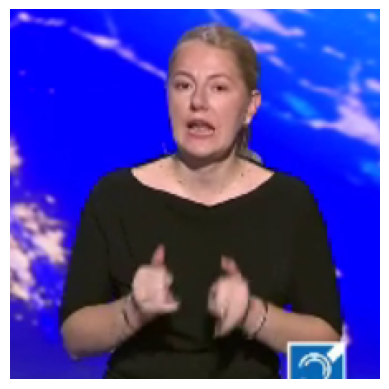

In [3]:
import matplotlib.pyplot as plt
import numpy as np

for i, batch in enumerate(
    iter_window_batches(
        '/home/radumicea/Projects/University/LinguSign/protv/scraped/2025/11/08/62589613-2.seg.mp4'
    )
):
    if i == 60:
        print(batch.shape)

        window = batch[0]

        frames = window.permute(1, 2, 3, 0)
        frame = frames[0]

        print(frame.min())
        print(frame.max())

        print(frame.shape)

        plt.imshow(((frame * std_cpu + mean_cpu) * 255.0).numpy().astype(np.uint8))
        plt.axis('off')
        plt.show()

        break

## Extract features

In [4]:
from libs.bsl1k.models import InceptionI3d


W, S = 8, 2  # window, stride (frames)
BATCH = 128


i3d = InceptionI3d(
    num_classes=5383,
    num_in_frames=W,
)

ckpt = torch.load('../libs/bsl1k/bsl5k.pth.tar', map_location='cpu')
state = ckpt['state_dict']
# If checkpoint was saved with DataParallel and has 'module.' prefixes, strip them:
if next(iter(state)).startswith('module.'):
    state = {k.replace('module.', '', 1): v for k, v in state.items()}
i3d.load_state_dict(state, strict=True)

i3d = torch.nn.DataParallel(i3d).cuda().eval()
i3d.requires_grad_(False)


captured = []
printed = False


def hook(_m, _i, o):
    # o: [B, 1024, T / 8, H / 32, W / 32]
    global printed
    if not printed:
        print(o.shape)
        printed = True
    captured.append(o.detach().cpu())  # [B, 1024, 1, 7, 7]


h = i3d.module.end_points['Mixed_5c'].register_forward_hook(hook)

In [ ]:
import contextlib
import os
import zstandard as zstd


def save_npy_zst(path: str, array: np.ndarray, level: int = 2) -> str:
    if path.endswith('.npz'):
        out_path = path[:-4] + '.npy.zst'
    elif path.endswith('.npy.zst'):
        out_path = path
    else:
        out_path = path + '.npy.zst'

    cctx = zstd.ZstdCompressor(level=level)

    with open(out_path, 'wb') as f:
        with cctx.stream_writer(f) as compressor:
            np.save(compressor, array)

    return out_path


torch.backends.cudnn.benchmark = True

with torch.inference_mode():
    for root, _, files in os.walk('scraped'):
        for file in files:
            if not file.endswith('.seg.mp4'):
                continue
            video_path = os.path.join(root, file)
            out_path = video_path.replace('.mp4', '.npy.zst')

            if os.path.exists(out_path):
                print(f'[EXISTS] {video_path} -> {out_path}')
                continue

            captured.clear()

            use_amp = device == 'cuda'
            ctx = (
                torch.autocast('cuda', dtype=torch.float16)
                if use_amp
                else contextlib.nullcontext()
            )

            with ctx:
                for batch in iter_window_batches(video_path):  # expects [B,3,8,224,224]
                    assert (
                        batch.dim() == 5
                        and batch.size(0) <= BATCH
                        and batch.size(1) == 3
                        and batch.size(2) == 8
                        and batch.size(3) == 224
                        and batch.size(4) == 224
                    ), f'bad batch {tuple(batch.shape)}'
                    _ = i3d(batch)  # hook collects [B, 1024, 1, 7, 7]

            if not captured:
                print(f'[WARN] {video_path}: no 8-frame windows. Skipping')
                continue

            feats = torch.cat(captured, dim=0).numpy()  # [N, 1024, 1, 7, 7]
            save_npy_zst(out_path, feats)
            print(f'[OK] {video_path}  tokens={feats.shape[0]} -> {out_path}')

h.remove()

[EXISTS] scraped/2025/05/05/62540739-2.seg.mp4 -> scraped/2025/05/05/62540739-2.seg.npy.zst
[EXISTS] scraped/2025/05/29/62547811-2.seg.mp4 -> scraped/2025/05/29/62547811-2.seg.npy.zst
[EXISTS] scraped/2025/05/10/62542520-2.seg.mp4 -> scraped/2025/05/10/62542520-2.seg.npy.zst
[EXISTS] scraped/2025/05/15/62543845-2.seg.mp4 -> scraped/2025/05/15/62543845-2.seg.npy.zst
[EXISTS] scraped/2025/05/31/62548235-2.seg.mp4 -> scraped/2025/05/31/62548235-2.seg.npy.zst
[EXISTS] scraped/2025/05/23/62546036-2.seg.mp4 -> scraped/2025/05/23/62546036-2.seg.npy.zst
[EXISTS] scraped/2025/05/13/62543055-2.seg.mp4 -> scraped/2025/05/13/62543055-2.seg.npy.zst
[EXISTS] scraped/2025/05/18/62544587-2.seg.mp4 -> scraped/2025/05/18/62544587-2.seg.npy.zst
[EXISTS] scraped/2025/05/12/62542841-2.seg.mp4 -> scraped/2025/05/12/62542841-2.seg.npy.zst
[EXISTS] scraped/2025/05/24/62546375-2.seg.mp4 -> scraped/2025/05/24/62546375-2.seg.npy.zst
[EXISTS] scraped/2025/05/20/62545135-2.seg.mp4 -> scraped/2025/05/20/62545135-2.